In [1]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.4 MB/s eta 0:00:00


In [2]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from pypfopt import risk_models
from pypfopt.plotting import plot_efficient_frontier

from matplotlib.ticker import FuncFormatter


In [5]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Читаем и подготавливаем данные


In [3]:
crypto = ['Aave', 
          'BinanceCoin', 
          'Bitcoin', 
          'Cardano', 
          'ChainLink', 
          'Cosmos', 
          'CryptocomCoin', 
          'Dogecoin', 
          'EOS', 
          'Ethereum', 
          'Iota', 
          'Litecoin', 
          'Monero', 
          'NEM', 
          'Polkadot', 
          'Solana', 
          'Stellar', 
          'Tether', 
          'Tron', 
          'Uniswap', 
          'USDCoin', 
          'WrappedBitcoin', 
          'XRP'
          ]

In [39]:
path = '/content/drive/MyDrive/data/cryptocurrency_rates/coin_{}.csv'

coins_info = pd.DataFrame()
for coin in crypto:
  coins_info = pd.concat([coins_info, pd.read_csv(path.format(coin))])

In [40]:
coins_info['Date'] = pd.to_datetime(coins_info['Date'])
coins_info['Date'] = coins_info['Date'].dt.date

coins_info['Rate'] = coins_info['Close']
coins_info = coins_info[['Name', 'Date', 'Rate']]
coins_info_copy = coins_info.copy()

# coins_info['Rate_diff'] = coins_info.groupby('Name').apply(lambda x: x.sort_values('Date')).groupby('Name')['Rate'].diff()


In [41]:
coins_info[['Name', 'Date']].groupby('Name').agg(['min', 'max'])

Date            
                        min         max
Name                                   
Aave             2020-10-05  2021-07-06
Binance Coin     2017-07-26  2021-07-06
Bitcoin          2013-04-29  2021-07-06
Cardano          2017-10-02  2021-07-06
Chainlink        2017-09-21  2021-07-06
Cosmos           2019-03-15  2021-07-06
Crypto.com Coin  2018-12-15  2021-07-06
Dogecoin         2013-12-16  2021-07-06
EOS              2017-07-02  2021-07-06
Ethereum         2015-08-08  2021-07-06
IOTA             2017-06-14  2021-07-06
Litecoin         2013-04-29  2021-07-06
Monero           2014-05-22  2021-07-06
NEM              2015-04-02  2021-07-06
Polkadot         2020-08-21  2021-07-06
Solana           2020-04-11  2021-07-06
Stellar          2014-08-06  2021-07-06
TRON             2017-09-14  2021-07-06
Tether           2015-02-26  2021-07-06
USD Coin         2018-10-09  2021-07-06
Uniswap          2020-09-18  2021-07-06
Wrapped Bitcoin  2019-01-31  2021-07-06
XRP              2013-08-05  2021-07-06

Для анализа возьмем набор криптовалют, по которым у нас есть данные до 2018 года

In [42]:
using_crypto = ['Binance Coin', 'Bitcoin', 'Cardano', 'EOS', 'Ethereum', 'IOTA', 'TRON', 'XRP']

In [43]:
coins_info = coins_info[coins_info['Name'].isin(using_crypto)]

In [ ]:
coins_info[['Name', 'Date']].groupby('Name').agg(['min', 'max'])

In [24]:
first_date = coins_info[['Name', 'Date']].groupby('Name').min().Date.max()

In [46]:
first_date

datetime.date(2017, 10, 2)

In [47]:
coins_info = coins_info[coins_info['Date'] > first_date]
coins_info.head()

,Name,Date,Rate
69,Binance Coin,2017-10-03,1.82070
70,Binance Coin,2017-10-04,1.60148
71,Binance Coin,2017-10-05,1.67849
72,Binance Coin,2017-10-06,1.57991
73,Binance Coin,2017-10-07,1.58425


In [48]:
pivot_coins = coins_info.pivot(index='Date', columns='Name', values='Rate')
pivot_coins.head()

Name,Binance Coin,Bitcoin,Cardano,EOS,Ethereum,IOTA,TRON,XRP
Date,,,,,,,,
2017-10-03,1.82070,4317.479980,0.020816,0.631230,292.463013,0.561712,0.002447,0.203318
2017-10-04,1.60148,4229.359863,0.021931,0.601539,292.657990,0.546982,0.003250,0.214774
2017-10-05,1.67849,4328.410156,0.021489,0.606157,295.863007,0.540915,0.003320,0.237016
2017-10-06,1.57991,4370.810059,0.018539,0.599844,308.588013,0.503448,0.002996,0.234039
2017-10-07,1.58425,4426.890137,0.020941,0.588553,311.123993,0.538529,0.002459,0.238610


In [ ]:
pivot_coins.index

In [37]:
set(coins_info.Name)

{'Binance Coin', 'Bitcoin', 'Cardano', 'EOS', 'Ethereum', 'IOTA', 'TRON'}

In [51]:
coins_info.head()

,Name,Date,Rate
69,Binance Coin,2017-10-03,1.82070
70,Binance Coin,2017-10-04,1.60148
71,Binance Coin,2017-10-05,1.67849
72,Binance Coin,2017-10-06,1.57991
73,Binance Coin,2017-10-07,1.58425


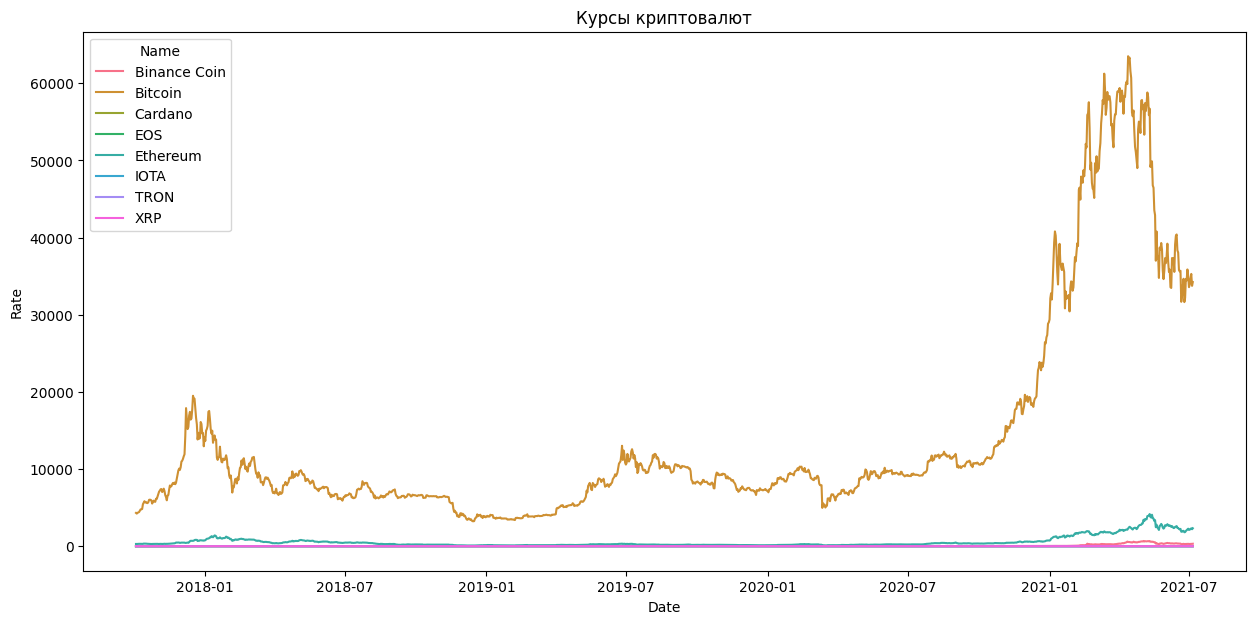

In [52]:
plt.figure(figsize=(15, 7))

sns.lineplot(data=coins_info, x='Date', y='Rate', hue='Name')
plt.title('Курсы криптовалют')
plt.show()

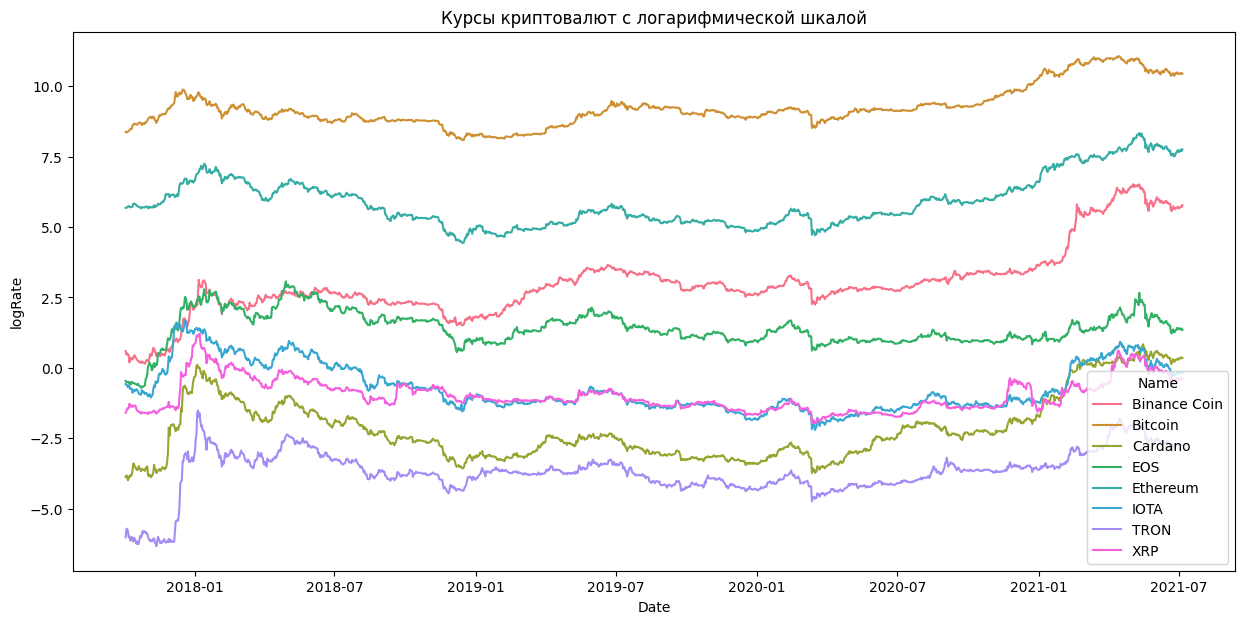

In [53]:
plt.figure(figsize=(15, 7))

coins_info['logRate'] = np.log(coins_info.Rate)
sns.lineplot(data=coins_info, x='Date', y='logRate', hue='Name')
plt.title('Курсы криптовалют с логарифмической шкалой')
plt.show()

По графику видно, что курсы криптовалют имею общие тенденции к падению и росту

Теперь составим эффективный портфель согласно теории Марковица

In [54]:
mu = expected_returns.mean_historical_return(pivot_coins)
S = risk_models.sample_cov(pivot_coins)
S

Name,Binance Coin,Bitcoin,Cardano,EOS,Ethereum,IOTA,TRON,XRP
Name,,,,,,,,
Binance Coin,1.151436,0.422831,0.598733,0.626840,0.517737,0.601044,0.564873,0.496076
Bitcoin,0.422831,0.446354,0.445177,0.467711,0.408974,0.437681,0.473486,0.359716
Cardano,0.598733,0.445177,1.754826,0.771048,0.629771,0.839488,0.858425,0.839068
EOS,0.626840,0.467711,0.771048,1.328283,0.665259,0.770616,0.877304,0.751791
Ethereum,0.517737,0.408974,0.629771,0.665259,0.695695,0.609966,0.624164,0.564009
IOTA,0.601044,0.437681,0.839488,0.770616,0.609966,1.209651,0.661442,0.668950
TRON,0.564873,0.473486,0.858425,0.877304,0.624164,0.661442,2.016212,0.760366
XRP,0.496076,0.359716,0.839068,0.751791,0.564009,0.668950,0.760366,1.341140


In [55]:
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

In [56]:
print("Оптимальные веса портфеля:")
for coin, weight in cleaned_weights.items():
    print(f"{coin}: {weight:.4f}")

Оптимальные веса портфеля:
Binance Coin: 0.8413
Bitcoin: 0.0000
Cardano: 0.1587
EOS: 0.0000
Ethereum: 0.0000
IOTA: 0.0000
TRON: 0.0000
XRP: 0.0000


In [57]:
ef.portfolio_performance(verbose=True)

Expected annual return: 152.0%
Annual volatility: 100.9%
Sharpe Ratio: 1.49


(1.519854133506146, 1.0094686328228861, 1.485785773562812)

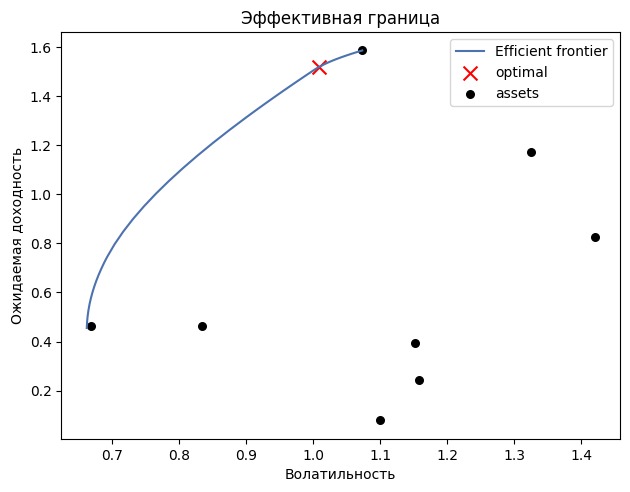

In [58]:
cla = CLA(mu, S)
plot_efficient_frontier(cla)
plt.title("Эффективная граница")
plt.xlabel("Волатильность")
plt.ylabel("Ожидаемая доходность")
plt.show()

Как можно видеть, все найденные портфели имеют очень большой уровень риска. Для того, чтобы сделать более надежный портфель, которые можно будет сравнить с портфелями акция добавим в набор криптовалют USDC в качестве безрискового актива.

In [60]:
coins_info_copy
using_crypto = ['Binance Coin', 'Bitcoin', 'Cardano', 'EOS', 'Ethereum', 'IOTA', 'TRON', 'XRP', 'USD Coin']
coins_info = coins_info_copy[coins_info_copy['Name'].isin(using_crypto)]
first_date = coins_info[['Name', 'Date']].groupby('Name').min().Date.max()
coins_info = coins_info[coins_info['Date'] > first_date]
pivot_coins = coins_info.pivot(index='Date', columns='Name', values='Rate')

mu = expected_returns.mean_historical_return(pivot_coins)
S = risk_models.sample_cov(pivot_coins)

In [70]:
max_volatility = 0.10
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
raw_weights = ef.efficient_risk(target_volatility=max_volatility)
cleaned_weights = ef.clean_weights()

In [71]:
print(f"Оптимальные веса портфеля при максимальной волатильности {max_volatility}:")
for coin, weight in cleaned_weights.items():
    print(f"{coin}: {weight:.4f}")

Оптимальные веса портфеля при максимальной волатильности 0.1:
Binance Coin: 0.0662
Bitcoin: 0.0000
Cardano: 0.0265
EOS: 0.0000
Ethereum: 0.0000
IOTA: 0.0000
TRON: 0.0000
USD Coin: 0.9073
XRP: 0.0000


In [72]:
ef.portfolio_performance(verbose=True)

Expected annual return: 11.6%
Annual volatility: 10.0%
Sharpe Ratio: 0.96


(0.11643120071898824, 0.10000000335310219, 0.9643119748555165)

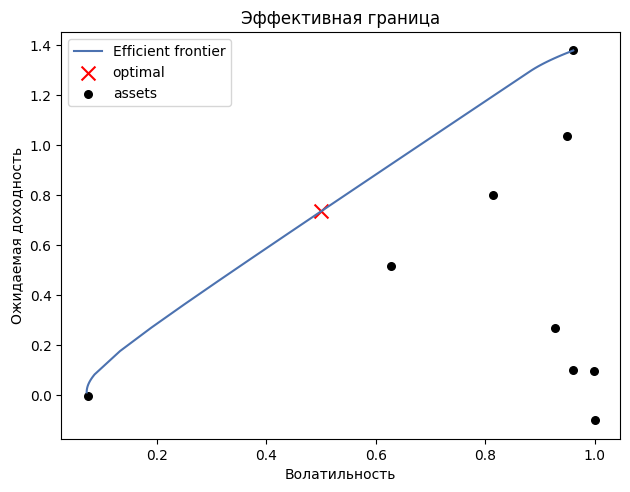

In [69]:
cla = CLA(mu, S)
plot_efficient_frontier(cla)
plt.title("Эффективная граница")
plt.xlabel("Волатильность")
plt.ylabel("Ожидаемая доходность")
plt.show()

Как мы видим при использовании безрискового актива и ограничения волатильности в портфеле можно добиться цифр, сравнимых с портфелями из акций. Более подробное сравнение в текстовой части.